<a href="https://colab.research.google.com/github/andrewbowen19/CUNY-SQLBridge/blob/main/notebooks/bowen_final_data604.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA604 Final Project
Andrew Bowen   
CUNY School of Professional Studies - Data Science   
DATA 604: Simulation & Modeling Techniques

## Introduction
In this project I simulate trip times for the Metropolitan Transit Authority's (MTA) subway system in New York City. The NYC subway system services over. a [million riders a day](https://new.mta.info/agency/new-york-city-transit/subway-bus-ridership-2021), and is one of the most important public transit systems in the world. Post-pandemic, delays and long commutes are increasingly becoming a part of New Yorkers' lives again. Being able to accurately simulate travel times for a given subway ride between or within a given borough can help riders understand when to arrive for trains, and hopefully reduce commute times.

As a resident of New York City, and frequent user of public transit, this is work that impacts me on a day-to-day basis. The simulation code I later write is written in [Sympy](https://simpy.readthedocs.io/en/latest/contents.html), a python simulation library. I relied on their [tutorial for car washes](https://simpy.readthedocs.io/en/latest/examples/carwash.html?highlight=car%20wash), as that models a similar queuing process to the protocol of NYC subways

In [14]:
!pip install --q simpy

In [2]:
import requests as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from numpy.random import normal

In [3]:
# Import module and set up simpy environment variable
import simpy

env = simpy.Environment()

## Historical Data

I found [this dataset](https://data.ny.gov/Transportation/MTA-Access-A-Ride-Ride-Time-Beginning-2016/wtm4-vjm7) from NYC Open Data containing ride times for different routes between locations within New York City. This will be helpful for later *verification & validation* of our simulated travel times.

In [4]:
# Look up historical dataset
response = re.get("https://data.ny.gov/resource/wtm4-vjm7.json")
df = pd.json_normalize(response.json())
df.head()

,service_date,month,year,provider_type,weekday_weekend,peak_offpeak,distance_category,origin_borough,destination_borough,totalridetimetrips,actualridetimetrips,tripsupto100percentageoftime,trips100to125percentageoftime,trips125to150percentageoftime,trips150to200percentageoftime,tripsover200percentageoftime
0,2021-10-07T00:00:00.000,10,2021,Primary,Weekday,OffPeak,0-3 miles,Bronx,Other,82,1487,61,7,7,4,3
1,2021-10-07T00:00:00.000,10,2021,Primary,Weekday,OffPeak,0-3 miles,Bronx,Bronx,2856,55057,2113,257,228,143,114
2,2021-10-07T00:00:00.000,10,2021,Primary,Weekday,OffPeak,0-3 miles,Bronx,Manhattan,190,4451,141,17,15,10,8
3,2021-10-07T00:00:00.000,10,2021,Primary,Weekend,OffPeak,0-3 miles,Bronx,Other,46,793,34,4,4,2,2
4,2021-10-07T00:00:00.000,10,2021,Primary,Weekend,OffPeak,0-3 miles,Bronx,Manhattan,82,1694,61,7,7,4,3


## Historical Average Trip Times
One measure that would be valuable for us to know when we are simulating trip times of different subway routes would be the average trip time of similar routes.

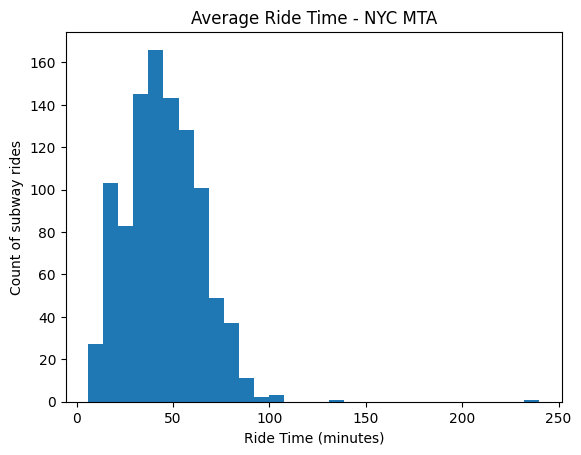

In [15]:
# Deriving average ride time on a column level based on total rides and total ride time
df["actualridetimetrips"] = df["actualridetimetrips"].astype(int)
df['totalridetimetrips']  = df['totalridetimetrips'] .astype(int)
df["average_ride_time"] = df["actualridetimetrips"] / df['totalridetimetrips']

# Plot average ride times
plt.hist(df['average_ride_time'], bins=30)
plt.title("Average Ride Time - NYC MTA")
plt.xlabel("Ride Time (minutes)")
plt.ylabel("Count of subway rides")
plt.show()

Our distribution of ride times look to be roughly normal (slightly skewed right given we can't have a negative trip time). Let's print out our summary statistics below using `describe` from `pandas`

In [6]:
# Capture important summary stats and print
mean_ride_time = df.average_ride_time.mean()
std_ride_time = df.average_ride_time.std()
df.describe()

,totalridetimetrips,actualridetimetrips,average_ride_time
count,1000.000000,1000.000000,1000.000000
mean,346.181000,13477.484000,44.933467
std,804.210131,24038.004672,19.509683
min,1.000000,7.000000,6.000000
25%,21.000000,761.500000,31.077202
50%,102.000000,4666.000000,43.550897
75%,308.500000,14617.000000,57.662823
max,10820.000000,296044.000000,240.000000


In [7]:
# Interested in seeing the average time per distance category
time_by_dist = df.groupby('distance_category')["average_ride_time"].mean()

In [8]:
# getting distance counts per origin - destination boro
count_boro_combos = df.groupby(["origin_borough", "destination_borough"])["distance_category"].count()
count_boro_combos

origin_borough  destination_borough
Bronx           Bronx                  34
                Brooklyn               23
                Manhattan              42
                Other                  29
                Queens                 33
                Staten Island           3
Brooklyn        Bronx                  23
                Brooklyn               41
                Manhattan              42
                Other                  30
                Queens                 42
                Staten Island          16
Manhattan       Bronx                  41
                Brooklyn               41
                Manhattan              41
                Other                  25
                Queens                 41
                Staten Island           9
Other           Bronx                  29
                Brooklyn               37
                Manhattan              24
                Other                  42
                Queens                 3

Since our variable of interest is the trip time (our *dependent* variable of interest), it'll be helpful to define our *independent* variables of interest that may have an impact on our target variable


- Distance of trip

# Simulation

I'm using the [SimPy car wash tutorial as a good example](https://simpy.readthedocs.io/en/latest/examples/carwash.html) of a similar process I'm trying to model. In general, we need to simulate based on some input (*independent*) variables, with the ride time being the output (*dependent*) variable. I pulled some constants from online search, such as using the [NYC MTA Wikipedia page](https://en.wikipedia.org/wiki/New_York_City_Subway) to find the number of trains used in NYC

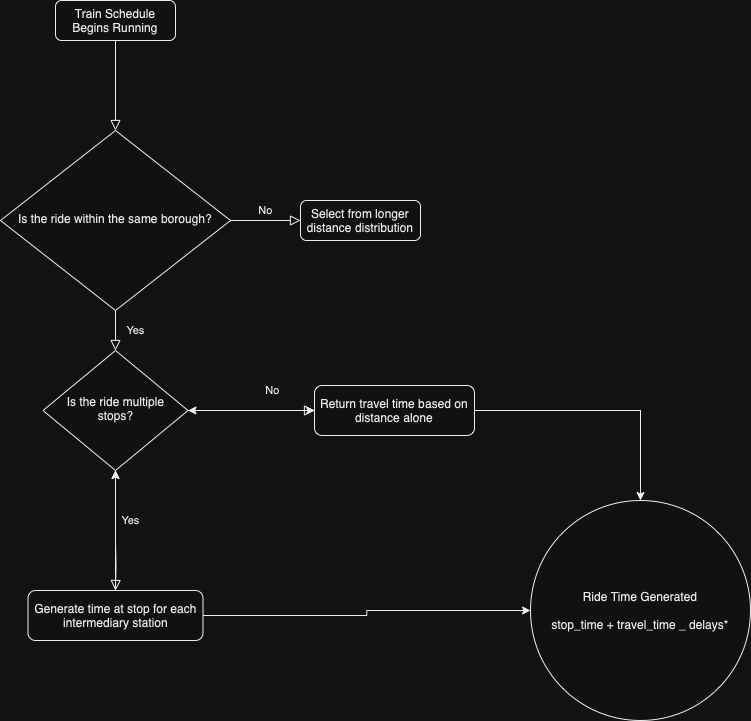

In [16]:
# Defining simulation constants
RANDOM_SEED = 10
NUM_TRAINS = 6418 # number of train cars per NYC track
SIM_TIME = 60 * 24 # simulation time in minutes
BOROUGHS = ["Bronx", "Brooklyn", "Manhattan", "Other", "Staten Island", "Queens"]

# Setting seed for reproducability
random.seed(RANDOM_SEED)


class TrainTrack(object):

  def __init__(self, env, num_trains, distance, origin_boro, destination_boro, name):
    self.env = env
    self.track = simpy.Resource(env, num_trains)
    self.distance = distance
    self.origin_boro = origin_boro
    self.destination_boro = destination_boro
    self.travel_velocity = random.triangular(0, 55, 17.4) / 60 # convert to miles per min
    # time to travel at a given average speed - this will be shorter than the total travel time
    self.time_to_travel = self.distance * self.travel_velocity
    self.name = name

  def trip(self, env):
    yield self.env.timeout(self.time_to_travel)
    print(f"Time to move from {self.origin_boro} to {self.destination_boro} \
            ({self.distance} mi): {self.time_to_travel} hr")

def get_num_stops(origin, destination):
  """
  Generate the number of stops for a given ride based on the origin and destination boro
  Trips between the same borough will have less stops on average than inter-borough trips
  """
  # Generate the number of stops based on
  if origin == destination:
    num_stops = random.triangular(1, 15, 4)
  else:
    num_stops = random.triangular(2, 40, 12)

  return int(num_stops)


def train_ride(env, name, distance, origin_boro, destination_boro, train, times_array):
  """
  The train process simulates the time taken due to stops, and delays from other trains
  """
  print(f"{origin_boro} => {destination_boro}")
  num_stops = get_num_stops(origin_boro, destination_boro)
  print(f"Num stops: {num_stops}")
  with train.track.request() as request:
    yield request
    for n in range(1, num_stops):
      # At each stop the train takes, some time passes. Most likely this is <1 minute but can be upt to 20 minutes within our simulation
      stop_time = random.triangular(0, 5, 0.5)
      print(f"Stop time for train {train.name} at stop {n}: {stop_time} min")
      train.time_to_travel += stop_time
      times_array.append(train.time_to_travel)
      yield env.timeout(stop_time)
  print(f'Travel time with stops: {train.time_to_travel}')


def setup(env, num_trains, times_array):
  """Setup function for Simpy environment"""
  for i in range(NUM_TRAINS):

    # Get train name and origin/dest boroughs
    train_name = f"Train {i}"
    print(train_name)
    origin = random.choice(BOROUGHS)
    destination = random.choice(BOROUGHS)
    distance = random.triangular(1, 25, 8)

    # Set up train track and simulate ride
    train = TrainTrack(env, num_trains, distance, origin, destination, train_name)
    yield env.process(train_ride(env, train_name, distance, origin, destination, train, times_array))


Train 0
Staten Island => Bronx
Num stops: 10
Stop time for train Train 0 at stop 1: 2.950543524624077 min
Stop time for train Train 0 at stop 2: 3.007702239122506 min
Stop time for train Train 0 at stop 3: 2.2077127677791553 min
Stop time for train Train 0 at stop 4: 0.6531810506616962 min
Stop time for train Train 0 at stop 5: 1.7159568504506986 min
Stop time for train Train 0 at stop 6: 1.1108983378544979 min
Stop time for train Train 0 at stop 7: 0.8920717174522155 min
Stop time for train Train 0 at stop 8: 3.969650765896831 min
Stop time for train Train 0 at stop 9: 4.721669858149969 min
Travel time with stops: 25.36065559545607
Train 1
Bronx => Other
Num stops: 14
Stop time for train Train 1 at stop 1: 0.9852036045275083 min
Stop time for train Train 1 at stop 2: 2.2956903025978166 min
Stop time for train Train 1 at stop 3: 1.5041025327981767 min
Stop time for train Train 1 at stop 4: 2.3414070306228485 min
Stop time for train Train 1 at stop 5: 2.2416566930814974 min
Stop time fo

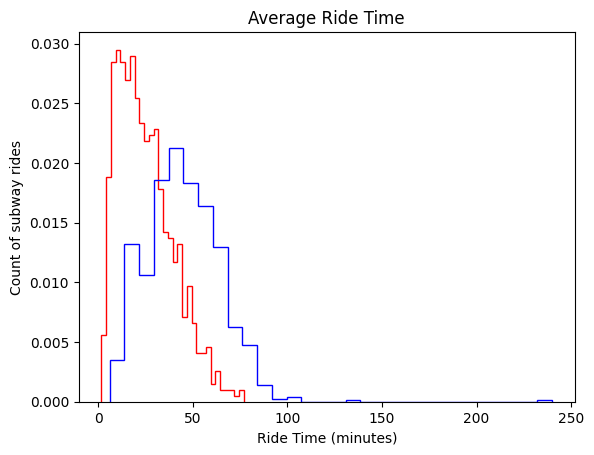

In [17]:

def run_simulation():
  ride_times = []
  # Create an environment and start the setup process
  env = simpy.Environment()
  env.process(setup(env, NUM_TRAINS, ride_times))

  # Execute the simulation!
  env.run(until=SIM_TIME)

  #Plot simulation results against observed values
  plt.hist(ride_times, bins=30, color="r", histtype='step', label="Simulation", density=True)
  plt.hist(df['average_ride_time'], bins=30, color="b", histtype='step', label="Simulation", density=True)
  plt.title("Average Ride Time")
  plt.xlabel("Ride Time (minutes)")
  plt.ylabel("Count of subway rides")

  return ride_times

ride_times = run_simulation()
plt.show()

Overall, our distribution has a center shifted left of our observed ride time mean. The simulated distribution also looks to be slightly skew-right, while the observed distribution looks to be more normally distributed.

## Verification & Validation


In [12]:
# No

In [13]:
abs_error =

SyntaxError: ignored

## Further Work
While our simulation of travel times for NYC MTA rides has some similarities to the

- More complete observed data
  - For example, exact distances of rides (rather than buckets of distance e.g., *0-3 miles*) could be helpful as a simulation parameter
- Expand beyond one train track
- Implement inter-dependence of trains. For example, if two trains are both running on the same line. If he train in front is delayed, that will delay the train behind it as well.

### TODO
- Add in multiple trains (e.g., `train 1, train 2`)
- Visualize output ride times to align to observed historical ride times
  - Calculate RMSE and run hypothesis test on simulated ride times
-



In [ ]:
print(random.seed())